In [1]:
import torch ,tarfile,os
import matplotlib.pyplot as plt 
import torch.nn as nn 
from torch.utils.data import random_split 
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torch.functional as F
from torch.utils.data.dataloader import DataLoader
torch.manual_seed(42)

## DATA PROCESSING

In [58]:
#the function will count number of images in all label directories
def count_images(path,classes,log=False):
    n_images  = 0 
    for i in classes:
        for j in os.listdir(f"{path}/{i}"):
            n_images += 1
        if log==True:
            print(f"{i} Done ")
    return int(n_images)


In [3]:
data_link  = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(data_link,".")

100%|██████████| 135107811/135107811 [00:08<00:00, 16811183.20it/s]


In [4]:
with tarfile.open("./cifar10.tgz","r:gz") as f:
    f.extractall(path="./data")

In [5]:
dataset = ImageFolder("data/cifar10/train",transform=ToTensor())
test_dataset = ImageFolder("data/cifar10/test",transform=ToTensor())

In [59]:
classes = dataset.classes
train_length  = count_images("data/cifar10/train/",classes)
test_length  = count_images("data/cifar10/test/",classes) 
batch_size = 128
train_length,test_length

(50000, 10000)

In [61]:
train_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

## BUILDING **CNN** MODEL

In [9]:
class CNNModel(nn.Module):
    def __init__(self,):
        super(CNNModel,self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(128*4*4,1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,10)
        )
    def forward(self,x):
        x = self.cnn(x)
        return x


In [10]:
model = CNNModel()
model

CNNModel(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=1024, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [11]:
lr = 0.001
adam = torch.optim.Adam
optimizer = adam(model.parameters(),lr=lr)
loss = nn.CrossEntropyLoss()
epochs =10 

## Training model

In [12]:
losses = []


for i in range(epochs):
    for step , (images,labels) in enumerate(train_loader):
        pred = model(images)
        loss_ = loss(pred,labels)
        losses.append(loss_.item())
        loss_.backward()
        optimizer.step()
        optimizer.zero_grad()
        if step % 100 == 0:
            print("STEP : {} LOSS : {}".format(step,loss_.item()))
    print("--Running EPOCH : {}".format(i))
    
    
    

STEP : 0 LOSS : 2.3011136054992676
STEP : 100 LOSS : 1.686197280883789
STEP : 200 LOSS : 1.4359678030014038
STEP : 300 LOSS : 1.5062562227249146
Running Epoch : 0
STEP : 0 LOSS : 1.277541160583496
STEP : 100 LOSS : 1.179917573928833
STEP : 200 LOSS : 0.9548459649085999
STEP : 300 LOSS : 1.0848448276519775
Running Epoch : 1
STEP : 0 LOSS : 1.0522187948226929
STEP : 100 LOSS : 1.026215672492981
STEP : 200 LOSS : 0.9843841791152954
STEP : 300 LOSS : 0.833760142326355
Running Epoch : 2
STEP : 0 LOSS : 0.824566125869751
STEP : 100 LOSS : 0.8113808631896973
STEP : 200 LOSS : 0.9163315892219543
STEP : 300 LOSS : 0.6564846038818359
Running Epoch : 3
STEP : 0 LOSS : 0.7917152643203735
STEP : 100 LOSS : 0.7144359350204468
STEP : 200 LOSS : 0.8975902199745178
STEP : 300 LOSS : 0.8082372546195984
Running Epoch : 4
STEP : 0 LOSS : 0.5866628289222717
STEP : 100 LOSS : 0.7391055226325989
STEP : 200 LOSS : 0.6877707242965698
STEP : 300 LOSS : 0.5415006279945374
Running Epoch : 5
STEP : 0 LOSS : 0.5279

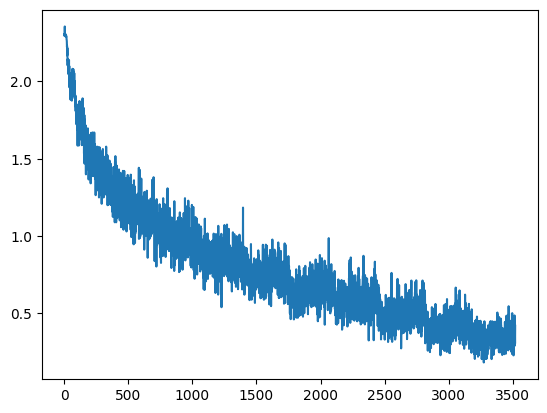

In [18]:
plt.plot(range(3520),losses)

## EVALUATION

In [19]:
total = 0
correct  = 0
model.eval()
with torch.no_grad():
    for images,labels in test_loader:
        outputs =  model(images)
        _,preds =  torch.max(outputs.data,axis=1)
        total +=  labels.size(0)
        correct  +=  (labels==preds).sum()

        

In [28]:
accuracy = correct/total
print("Accuracy of model : {:.2f} %".format(float(accuracy)*100))

Accuracy of model : 74.30 %


## MAKING PREDICTIONS 

In [67]:
def predict_img(img):
    img = img.unsqueeze(0)
    pred = model(img)
    _,out = torch.max(pred,1)
    return classes[out[0].item()]

def plot_img(img,label):
    plt.imshow(img.permute(1,2,0))
    pred = predict_img(img)
    text = "Prediction : {} ;label : {}".format(pred,classes[label])
    plt.title(text)
    plt.show()

In [57]:
for i in range(10):
    n = torch.randint(1,1000,(1,))[0]
    img,label = test_dataset[n]
    print("label: {} || Prediction : {}".format(classes[label],predict_img(img)))


label: airplane || Prediction : airplane
label: airplane || Prediction : airplane
label: airplane || Prediction : airplane
label: airplane || Prediction : truck
label: airplane || Prediction : truck
label: airplane || Prediction : airplane
label: airplane || Prediction : airplane
label: airplane || Prediction : airplane
label: airplane || Prediction : airplane
label: airplane || Prediction : airplane


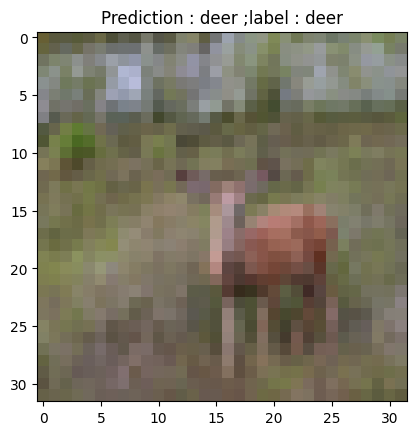

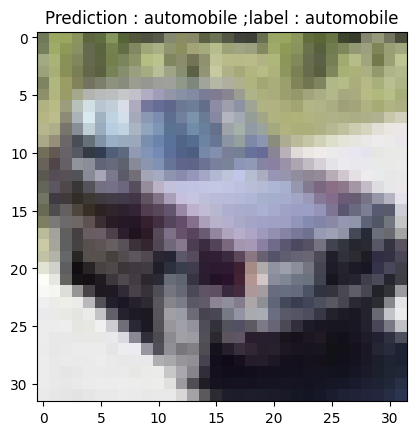

In [69]:
for i in range(2):
    n = torch.randint(1,5000,(1,))[0]
    img,label = test_dataset[n]
    plot_img(img,label)